In [1]:
import wandb
import torch
import sklearn
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs

In [2]:
# see GPU avaialability
cuda_available = torch.cuda.is_available()

% PER CLASS:

 SDG1      5.354267
SDG2      5.152979
SDG3      7.447665
SDG4      4.388084
SDG5      4.186795
SDG6      5.314010
SDG7      5.756844
SDG8      6.400966
SDG9      5.636071
SDG10     5.152979
SDG11     5.354267
SDG12     5.112721
SDG13    10.265700
SDG14     4.830918
SDG15     5.676329
SDG16     4.951691
SDG17     9.017713
dtype: float64


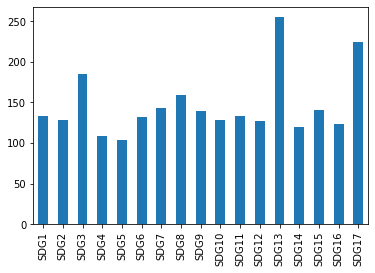

In [3]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data.iloc[-1000:,:]

# reformat data
sdg_lst = ['SDG1','SDG2','SDG3','SDG4','SDG5','SDG6','SDG7','SDG8','SDG9','SDG10','SDG11','SDG12','SDG13','SDG14','SDG15','SDG16','SDG17']
data['y'] = data[sdg_lst].values.tolist()
y = data['y']
X = data['abstract']

# plot ratio of data
class_weight = (data[sdg_lst].sum()/ data[sdg_lst].sum().sum())
print('% PER CLASS:\n\n', class_weight*100)
data[sdg_lst].sum().plot.bar()

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# add data to dataframes
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train
train_df.reset_index(inplace=True, drop=True)

eval_df = pd.DataFrame()
eval_df['text'] = X_val
eval_df['labels'] = y_val
eval_df.reset_index(inplace=True, drop=True)

# get number of classes
label_count = len(sdg_lst)

In [7]:
eval_df

,text,labels
0,Forests cover 30.7 per cent of the Earthâs s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,Goal 4: Ensure Inclusive and Equitable Quality...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"Goal 7: Ensure Access to Affordable, Reliable,...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"Goal Protect, restore and promote U g 15 susta...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,PROGRESS OF GOAL 2 IN 2016 Goal 2 aims to end ...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
295,"Basic infrastructure like roads, information a...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
296,This paper describes work that has been done o...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
297,PROGRESS OF GOAL 4 IN 2017 Achieving inclusive...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
298,Almost 16% of global gross domestic product (G...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [4]:
def acc_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    acc = sklearn.metrics.accuracy_score(true, pred)
    return acc

def f1_macro_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='macro')
    return f1

def f1_micro_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='micro')
    return f1

def cm_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    cm = wandb.plot.confusion_matrix(probs=None, y_true=true, preds=pred, class_names=sdg_lst) #sklearn.metrics.multilabel_confusion_matrix(true, pred)
    return cm

In [5]:
# train with optimal parameters
# logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# # Optional model configuration
model_args = MultiLabelClassificationArgs(fp16= False,
                                          manual_seed = 4,
                                          use_multiprocessing = True,
                                          overwrite_output_dir=True,
                                          evaluate_during_training = True,
                                          num_train_epochs=10,
                                          learning_rate=0.0001,
                                          train_batch_size=20,
                                          eval_batch_size=20,
                                          warmup_steps=300,
                                          weight_decay=0.09,
                                          threshold=0.97,
                                          wandb_project = 'sasdghub_ml_classify',
                                          wandb_kwargs={
                                              'entity':'sasdghub'
                                                       }
                                         )

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=label_count,
        args=model_args,
        use_cuda=cuda_available,
        pos_weight=list((1/label_count)/class_weight),
        # show_running_loss=True,
)

# Train the model
model.train_model(train_df,
                      verbose=True,
                      eval_df=eval_df,
                      accuracy=acc_result,
                      f1_macro=f1_macro_result,
                      f1_micro=f1_micro_result,
                      cm=cm_result)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(
    eval_df,
    verbose=True,
    accuracy=acc_result,
    f1_macro=f1_macro_result,
    f1_micro=f1_micro_result,
    cm=cm_result
)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/700 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
C:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.
wandb: Currently logged in as: christopher-marais (sasdghub). Use `wandb login --relogin` to force relogin


Running Epoch 0 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 2 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 3 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 4 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 5 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 6 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 7 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 8 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 9 of 10:   0%|          | 0/35 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/300 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'LRAP': 0.8722923223571399, 'accuracy': 0.6266666666666667, 'f1_macro': 0.6247133664995932, 'f1_micro': 0.6266666666666667, 'cm': <wandb.viz.CustomChart object at 0x000002C2830CA4C0>, 'eval_loss': 0.23814820696910222}


In [6]:
# Make predictions with the model
# predictions, raw_outputs = model.predict(["sanitation and clean drinking water"])

#######################################################################################




freeze number of layers as a parameter
(Custom layer parameters) https://simpletransformers.ai/docs/tips-and-tricks/

select and save best model
https://datascience.stackexchange.com/questions/92630/save-and-load-simple-transformer-model

apply new model in apply script
https://simpletransformers.ai/docs/classification-models/

make testing dataset and train real classifier

get model embedding
https://stackoverflow.com/questions/70245796/loading-pool-layer-of-simple-transformer

train classifier for targets from embedding (SVM, random forrest, KNN, NN) https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html

modify so it can digest longer text (split training data into paragraphs that can be digested) # needs an update